# Multi-Agent Highway MDP — Demo Notebook

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os
from pathlib import Path
import mdp_module as mdp_mod
import multi_agent_highway_sql as highway_mod

## Run a simulation
We will run the built-in `simulate_highway_multiagent_sql` with modest settings so plots/animation finish fast.

In [2]:
# Parameters (feel free to tweak)
N = 30            # number of agents
T = 100           # time steps
seed = 7
num_lanes_total = 2
lane_directions = [1, 1]  # two lanes forward
lane_width = 5 #5meters

res = highway_mod.simulate_highway_multiagent_sql(
    N=N, T=T, seed=seed,
    num_lanes_total=num_lanes_total,
    lane_width=lane_width,
    lane_directions=lane_directions,
    store_history=True
)
list(res.keys())


['avg_rew_b',
 'avg_rew_e',
 'succ_b',
 'succ_e',
 'coll_b',
 'coll_e',
 'unav_b',
 'unav_e',
 'labels_b',
 'actions_b',
 'rewards_b',
 'labels_e',
 'actions_e',
 'rewards_e',
 'history_b',
 'history_e',
 'layout',
 'spacing']

## Plot: average rewards over time (behavior vs evaluation)

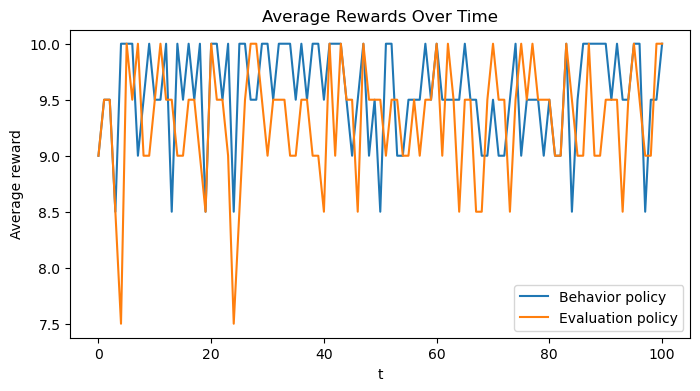

In [3]:
avg_rew_b = np.array(res['avg_rew_b'])
avg_rew_e = np.array(res['avg_rew_e'])

plt.figure(figsize=(8,4))
plt.plot(avg_rew_b, label='Behavior policy')
plt.plot(avg_rew_e, label='Evaluation policy')
plt.xlabel('t')
plt.ylabel('Average reward')
plt.legend()
plt.title('Average Rewards Over Time')
plt.show()


## Plot: label rates over time
Labels: 1=success, 2=collision, 3=unavailable

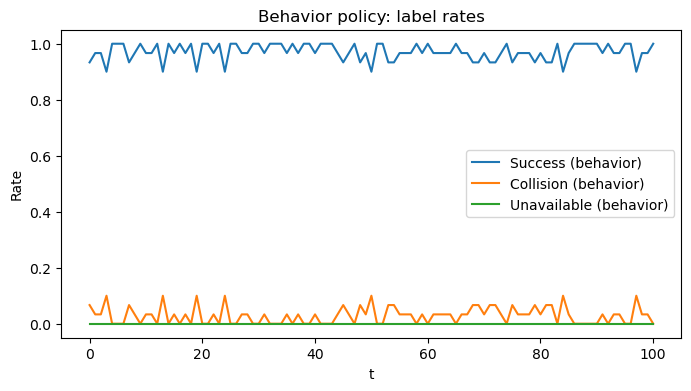

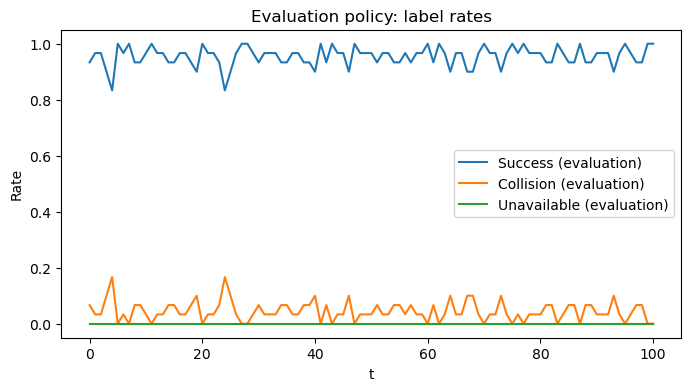

In [4]:
succ_b = np.array(res['succ_b']); coll_b = np.array(res['coll_b']); unav_b = np.array(res['unav_b'])
succ_e = np.array(res['succ_e']); coll_e = np.array(res['coll_e']); unav_e = np.array(res['unav_e'])

plt.figure(figsize=(8,4))
plt.plot(succ_b, label='Success (behavior)')
plt.plot(coll_b, label='Collision (behavior)')
plt.plot(unav_b, label='Unavailable (behavior)')
plt.xlabel('t')
plt.ylabel('Rate')
plt.legend()
plt.title('Behavior policy: label rates')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(succ_e, label='Success (evaluation)')
plt.plot(coll_e, label='Collision (evaluation)')
plt.plot(unav_e, label='Unavailable (evaluation)')
plt.xlabel('t')
plt.ylabel('Rate')
plt.legend()
plt.title('Evaluation policy: label rates')
plt.show()


## Spacing stats per lane

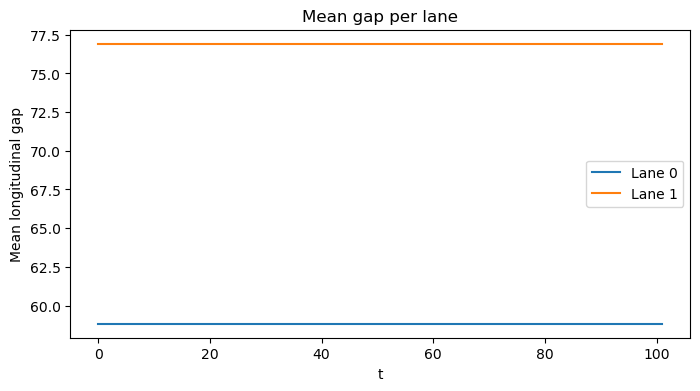

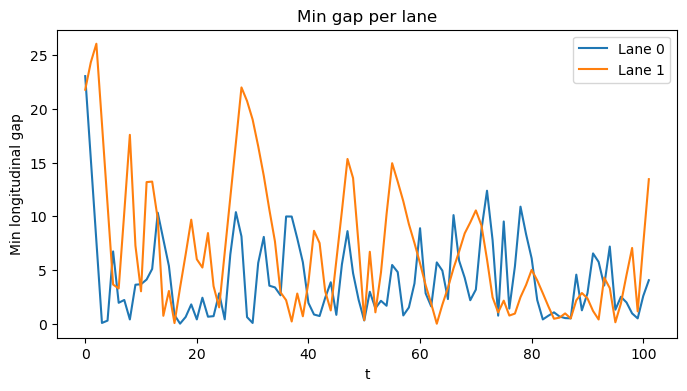

In [5]:
# Build spacing stats directly from the env history we already have in res
layout = res['layout']
spacing = res['spacing']

mean_gap = spacing['mean_gap_per_lane']
min_gap = spacing['min_gap_per_lane']

plt.figure(figsize=(8,4))
for ell in range(mean_gap.shape[1]):
    plt.plot(mean_gap[:, ell], label=f'Lane {ell}')
plt.xlabel('t')
plt.ylabel('Mean longitudinal gap')
plt.legend()
plt.title('Mean gap per lane')
plt.show()

plt.figure(figsize=(8,4))
for ell in range(min_gap.shape[1]):
    plt.plot(min_gap[:, ell], label=f'Lane {ell}')
plt.xlabel('t')
plt.ylabel('Min longitudinal gap')
plt.legend()
plt.title('Min gap per lane')
plt.show()


## Animation: agent trajectories on lanes
We plot $x$ along the ring (horizontal), lane index on vertical.

/var/folders/ly/jqp21h79689gdfzrwpydsm4mgt6yr8/T/ipykernel_7533/3927863910.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lane_width = float(res['layout']['lane_width'])
/var/folders/ly/jqp21h79689gdfzrwpydsm4mgt6yr8/T/ipykernel_7533/3927863910.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num_lanes = int(res['layout']['num_lanes_total'])


'highway_sim.gif'

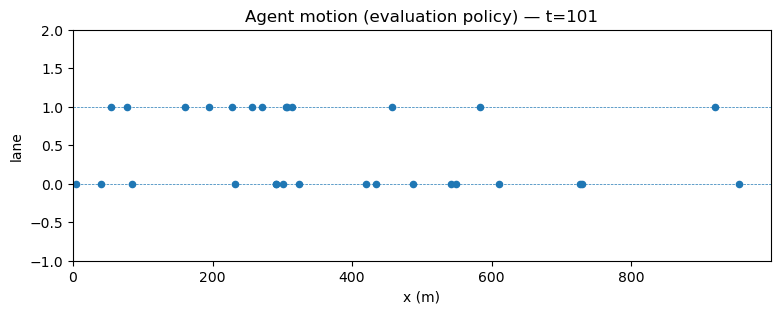

In [6]:
# Use evaluation rollout for the animation (could switch to behavior by swapping keys)
hist = res['history_e']
X = hist['x']    # (T+1, N)
LANE = hist['lane']  # (T+1, N)
lane_dirs = res['layout']['lane_directions']  # shape (num_lanes,)
lane_width = float(res['layout']['lane_width'])
num_lanes = int(res['layout']['num_lanes_total'])
road_length = float(np.max(X)) if np.max(X) > 0 else 1000.0  # rough axis scale

fig, ax = plt.subplots(figsize=(9, 3))
ax.set_xlim(0, road_length)
ax.set_ylim(-1, num_lanes)
ax.set_xlabel('x (m)')
ax.set_ylabel('lane')
ax.set_title('Agent motion (evaluation policy)')

# Draw lane centerlines
for ell in range(num_lanes):
    ax.axhline(ell, linestyle='--', linewidth=0.5)

scat = ax.scatter(X[0], LANE[0], s=20)

def update(frame):
    scat.set_offsets(np.c_[X[frame], LANE[frame]])
    ax.set_title(f'Agent motion (evaluation policy) — t={frame}')
    return scat,

anim = FuncAnimation(fig, update, frames=X.shape[0], interval=60, blit=True)

# Save GIF
out_path = Path('highway_sim.gif')
anim.save(out_path, writer=PillowWriter(fps=10))
out_path.as_posix()
